In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
with open('/Users/julianalverio/code/resnet/ObjectNet-Data/ObjectNet_predictions_d123.json') as f:
    predictions = json.load(f)

new_predictions = dict()
for prediction in predictions:
    keys = prediction.keys()
    image_id = prediction['image_id']
    top1 = prediction['resnet152'][0][0]
    new_predictions[image_id] = top1
predictions = new_predictions

In [3]:
with open('/Users/julianalverio/code/resnet/objectnet_to_imagenet_mapping') as f:
    mapping = eval(f.read())

In [4]:
imagenet2torch = dict()
for entry in mapping:
    imagenet_labels = entry['ImageNet_category_ids']
    torch_labels = entry['pytorch_ImageNet_category_ids']
    for imagenet_label, torch_label in zip(imagenet_labels, torch_labels):
        imagenet2torch[imagenet_label] = torch_label

In [5]:
with open('/Users/julianalverio/code/resnet/ObjectNet-Data/objectNet_data_10_19_19_d123.json') as f:
    data = json.load(f)

In [6]:
category_id_to_imagenet_label = dict()
for category in data['categories']:
    category_id_to_imagenet_label[category['id']] = category['ImageNet_category_ids']

In [7]:
# clean data: [[image_id, category, sphere_point, torch labels], ...]
clean_data = []
for annotation in data['annotations']:
    image_id = annotation['image_id']
    sphere_point = annotation['object_rotation_id']  # change 1
    category = annotation['category_id']
    
    imagenet_labels = category_id_to_imagenet_label[category]
    torch_labels = [imagenet2torch[label] for label in imagenet_labels]
    clean_data.append([image_id, category, sphere_point, torch_labels])

In [8]:
# scored_points: [[category, sphere_point, score (binary)], ...]
scored_points = []
for image_id, category, sphere_point, labels_list in clean_data:
    labels = set(labels_list)
    if image_id not in predictions:
        continue
    top1_prediction = predictions[image_id]
    if top1_prediction in labels:
        score = 1
    else:
        score = 0
    scored_points.append([category, sphere_point, score])

In [9]:
# compute the accuracy for each sphere_point and class combination

In [10]:
# key: (category, sphere_point)

# first, aggregate all the scores by sphere point and category
# value: list of binary scores
aggregate = dict()
for category, sphere_point, score in scored_points:
    if (category, sphere_point) not in aggregate:
        aggregate[(category, sphere_point)] = [score]
    else:
        aggregate[(category, sphere_point)].append(score)
# now, compute the accuracy from the aggregated scores
# value: number correct, number of examples
new_aggregate = dict()
for key, score_list in aggregate.items():
    new_aggregate[key] = [np.sum(score_list), len(score_list)]
aggregate = new_aggregate

In [11]:
# key: category
# value: idx, total correct, total examples

# now aggregate per each category
by_category = dict()
for (category, sphere_point), scores in aggregate.items():
    if category not in by_category:
        by_category[category] = [[idx, 0, 0] for idx in range(50)]
    by_category[category][sphere_point][1] = scores[0]
    by_category[category][sphere_point][2] = scores[1]
for category in by_category.keys():
    by_category[category] = sorted(by_category[category], key=lambda x: (x[1]/x[2] if x[2] !=0 else 0, x[2]), reverse=True)

In [12]:
# first approach: average together Nth-best sphere point, regardless of class size

# weighted takes into account the size of the class; unweighted does not
unweighted_results = np.zeros((50))  # change 2
weighted_results = np.zeros((50))  # change 2
num_examples_results = np.zeros((50))  # change 2
for N in range(50):  # change 2
    running_correct = []
    running_accuracy = []
    running_num_examples = []
    for category in by_category.keys():
        _, correct, num_examples = by_category[category][N]
        if num_examples != 0:
            accuracy = correct / num_examples
            running_accuracy.append(accuracy)
        running_correct.append(correct)
        running_num_examples.append(num_examples)
    unweighted_results[N] = np.mean(running_accuracy)
    weighted_results[N] = np.sum(running_correct) / np.sum(running_num_examples) 
    num_examples_results[N] = np.sum(running_num_examples)

In [13]:
weighted_results = weighted_results.tolist()
unweighted_results = unweighted_results.tolist()


In [35]:
a={}
for i in range(len(unweighted_results)):
    a[i+1] = unweighted_results[i]

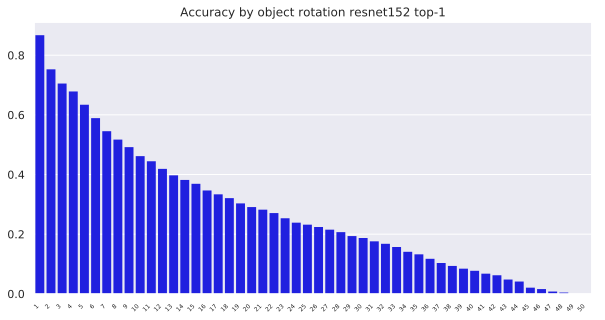

In [36]:
%config InlineBackend.figure_format = 'svg'
sns.set_context(rc = {'patch.linewidth': 0.0})
plt.figure(figsize=(10, 5))
plt.xticks(rotation=45, horizontalalignment='right', fontsize='6');
objectRotationCountDF = pd.DataFrame([a])
plot = sns.barplot(data=objectRotationCountDF, color='blue').set_title("Accuracy by object rotation resnet152 top-1");
plt.savefig('/Users/julianalverio/Desktop/unweighted.svg', format='svg')